In [55]:
import numpy as np
import GPy
import xarray as xr
import matplotlib.pyplot as plt
from haversine import haversine, Unit

In [211]:
# Define a manual Gaussian function
def gaussian(x, mean, amplitude, stddev):
    """Generates a Gaussian curve."""
    return amplitude * np.exp(-((x - mean) ** 2) / (2 * stddev ** 2))

# Gap fill function with spatial dependence applied at each time step
def gap_fill_station_per_time(dataset, target_station_id, var_name='temperature'):
    """
    Performs gap filling for a target station using data from surrounding stations.
    Applies Gaussian Process Regression (GPR) at each time step, considering only spatial dependence.
    
    Parameters:
    - dataset: xarray.Dataset containing the station data
    - target_station_id: The station ID of the target station to fill
    - var_name: The name of the variable to be filled (e.g., 'temperature')
    
    Returns:
    - filled_dataset: xarray.Dataset with filled values for the target station
    - uncertainty_dataset: xarray.Dataset with uncertainty values (in same units as temperature)
    """
    lat = dataset['lat'].values
    lon = dataset['lon'].values
    time = dataset['time'].values
    n_time = len(time)

    ref_lat, ref_lon = lat[target_station_id - 1], lon[target_station_id - 1]
    
    surrounding_stations = [id_ for id_ in dataset['station_id'].values if id_ != target_station_id]
    target_data = dataset[var_name].sel(station_id=target_station_id).values

    filled_data = target_data.copy()
    gpr_std_all = np.empty_like(target_data)

    # Normalize the lat/lon coordinates into a local Cartesian system
    def latlon_to_local_cartesian(lat, lon, ref_lat, ref_lon):
        x = np.array([haversine((ref_lat, lon[i]), (ref_lat, ref_lon), unit=Unit.KILOMETERS) for i in range(len(lon))])
        y = np.array([haversine((lat[i], ref_lon), (ref_lat, ref_lon), unit=Unit.KILOMETERS) for i in range(len(lat))])
        return x, y

    # Prepare the target station's spatial coordinates (latitude and longitude)
    x_target, y_target = latlon_to_local_cartesian([ref_lat], [ref_lon], ref_lat, ref_lon)

    # Loop through each time step and apply GPR
    for t in range(n_time):
        valid_temp_list = []
        x_all, y_all = [], []

        # Gather data for this time step for all surrounding stations
        for station_id in surrounding_stations:
            data = dataset[var_name].sel(station_id=station_id).values
            
            # Check if the station has valid data at this time step
            if not np.isnan(data[t]):
                # Convert the lat/lon coordinates to Cartesian
                x, y = latlon_to_local_cartesian([lat[station_id - 1]], [lon[station_id - 1]], ref_lat, ref_lon)
                
                # Append spatial coordinates and temperature data
                x_all.append(x[0])
                y_all.append(y[0])
                valid_temp_list.append(data[t])

        # Perform GPR only if there is valid data from surrounding stations
        if len(valid_temp_list) > 0:
            coords = np.column_stack([x_all, y_all])
            valid_temp_all = np.array(valid_temp_list)[:, None]

            # Use an RBF kernel with a bias term for spatial dependence
            kernel = GPy.kern.RBF(input_dim=2, variance=10.0, lengthscale=1.0) + GPy.kern.Bias(input_dim=2)
            
            # Create and optimize the Gaussian Process model
            gpr_model = GPy.models.GPRegression(coords, valid_temp_all, kernel)
            gpr_model.optimize()

            # Predict the missing value for the target station at this time step
            target_coords = np.array([x_target[0], y_target[0]]).reshape(1, -1)
            gpr_pred, gpr_var = gpr_model.predict(target_coords)


            filled_data[t] = gpr_pred[0, 0]
            gpr_std_all[t] = np.sqrt(gpr_var[0, 0])

    # Return the filled dataset and uncertainty dataset as xarray
    filled_dataset = xr.Dataset(
        {var_name: (['time'], filled_data)},
        coords={'time': dataset['time']}
    )
    
    uncertainty_dataset = xr.Dataset(
        {f'{var_name}_uncertainty': (['time'], gpr_std_all)},
        coords={'time': dataset['time']}
    )

    return filled_dataset, uncertainty_dataset

In [225]:
# Example: Create synthetic buoy (station) data with lat/lon features and a spike
n_time = 100
n_stations = 10
time = np.linspace(0, 10, n_time)
station_ids = np.arange(1, n_stations + 1)
latitudes = np.random.uniform(30, 40, n_stations)  # Random latitudes between 30° and 35°
longitudes = np.random.uniform(-81, -80, n_stations)  # Random longitudes between -90° and -80°

# Initialize an empty dataset with lat/lon
dataset = xr.Dataset(coords={"station_id": station_ids, "time": time})
dataset['lat'] = ('station_id', latitudes)
dataset['lon'] = ('station_id', longitudes)

# Define spike parameters
spike_time = 5.0  # Physical time of the spike
spike_duration = 6  # Spike duration in time steps
spike_magnitude = 30.0  # The magnitude of the temperature spike
spike_stddev = 0.5  # Gaussian spike width (stddev)

# Create the Gaussian spike (pulse)
x = np.linspace(-spike_duration // 2, spike_duration // 2, spike_duration)
spike = gaussian(x, mean=0, amplitude=spike_magnitude, stddev=spike_stddev)

dataset['temperature'] = (('station_id', 'time'), np.empty((n_stations, n_time)) * np.nan)
# Generate data for each station and add the spike
for i in range(n_stations):
    base_data = (
        20 + 5 * np.exp(-0.2 * time) + 
        np.sqrt(i + 1) * 1.5 * np.sin(2 * np.pi * time / 5) + 
        np.random.normal(0, 1, n_time) + ((np.exp(-latitudes[i] / 100) * np.sqrt(2 * i + 1))))
    
    # Apply the Gaussian spike to all stations at the same physical time
    spike_time_index = np.argmin(np.abs(time - spike_time))
    base_data[spike_time_index - spike_duration // 2 : spike_time_index + spike_duration // 2] += (np.exp(-latitudes[i] / 100) * spike)

    # Add the data to the dataset
    dataset['temperature'].isel(station_id=i).values[:] = base_data

# Remove the spike from the target station (e.g., Station 2) to simulate missing data
target_station_id = 2
spike_time_index_target = np.argmin(np.abs(time - spike_time))
old_target = 1 * dataset['temperature'].sel(station_id=target_station_id)
dataset['temperature'].sel(station_id=target_station_id).isel(time=slice(spike_time_index_target - spike_duration, spike_time_index_target + spike_duration)).values[:] = np.nan

# Gap fill for a specific station using the surrounding stations (including lat/lon)
filled_data, uncertainty_data = gap_fill_station_per_time(dataset, target_station_id)

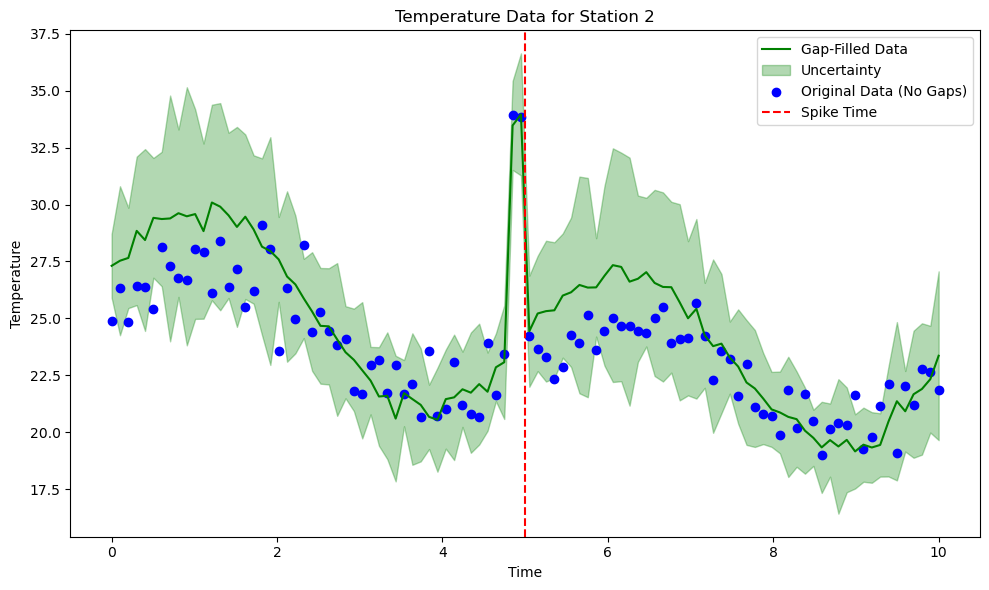

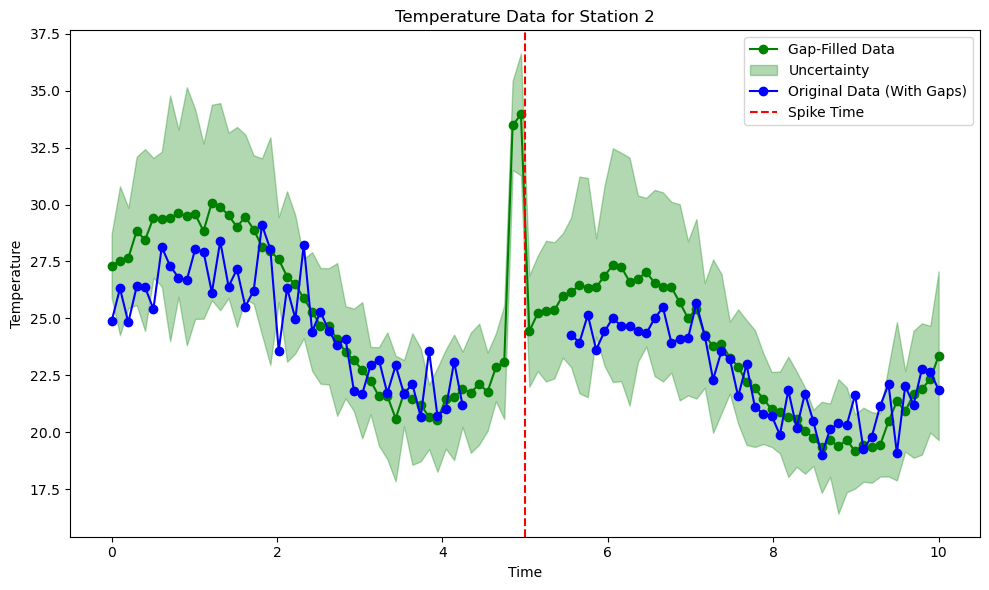

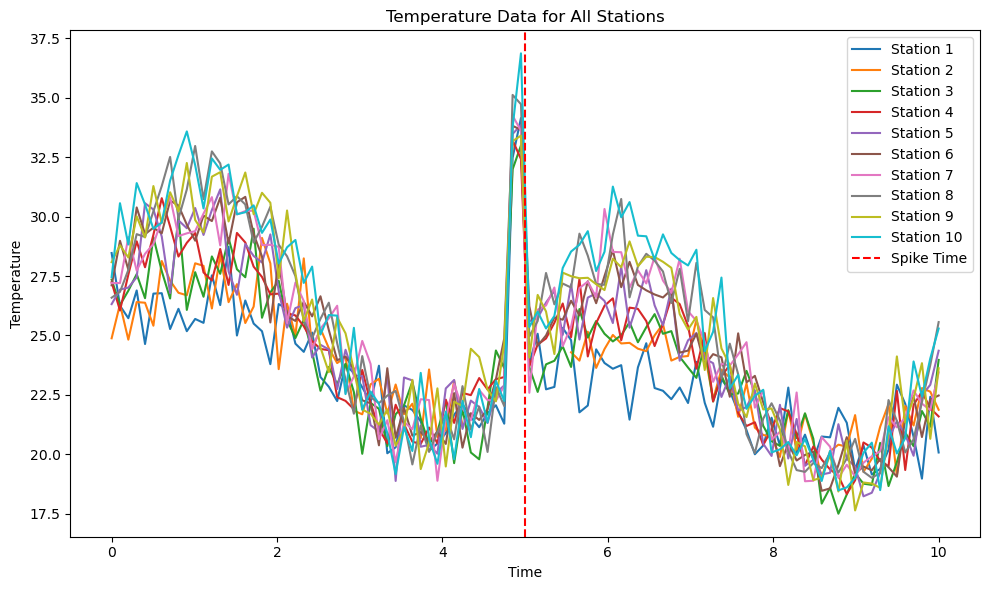

In [226]:
# Plot the original, gap-filled data, and uncertainty with error bars
time = dataset['time'].values
original_data = dataset['temperature'].sel(station_id=target_station_id).values
filled_values = filled_data['temperature'].values
uncertainties = uncertainty_data['temperature_uncertainty'].values

# Plotting the results (all in one plot)
plt.figure(figsize=(10, 6))

# Gap-filled data with error bars
plt.plot(time, filled_values, label='Gap-Filled Data', color='green')
plt.fill_between(time, filled_values - (2 * uncertainties), filled_values + (2 * uncertainties), color='green', alpha=0.3, label='Uncertainty')

# Original data with gaps
plt.scatter(time, old_target.values, label='Original Data (No Gaps)', color='blue', marker='o')

# Highlight the spike time on the plot
plt.axvline(x=spike_time, color='red', linestyle='--', label='Spike Time')

plt.title(f'Temperature Data for Station {target_station_id}')
plt.ylabel('Temperature')
plt.xlabel('Time')
plt.legend()

plt.tight_layout()
plt.show()

# Plotting the results (all in one plot)
plt.figure(figsize=(10, 6))

# Gap-filled data with error bars
plt.plot(time, filled_values, label='Gap-Filled Data', color='green', marker='o')
plt.fill_between(time, filled_values - (2 * uncertainties), filled_values + (2 * uncertainties), color='green', alpha=0.3, label='Uncertainty')

# Original data with gaps
plt.plot(time, original_data, label='Original Data (With Gaps)', color='blue', marker='o')

# Highlight the spike time on the plot
plt.axvline(x=spike_time, color='red', linestyle='--', label='Spike Time')

plt.title(f'Temperature Data for Station {target_station_id}')
plt.ylabel('Temperature')
plt.xlabel('Time')
plt.legend()

plt.tight_layout()
plt.show()

# Additional figure: Plot temperature data from all stations and their distances from the target station
plt.figure(figsize=(10, 6))

# Plot temperature data for all stations
for i in range(n_stations):
    station_data = dataset['temperature'].isel(station_id=i).values
    plt.plot(time, station_data, label=f'Station {i + 1}')

# Highlight the time of the spike
plt.axvline(x=spike_time, color='red', linestyle='--', label='Spike Time')

plt.title('Temperature Data for All Stations')
plt.ylabel('Temperature')
plt.xlabel('Time')
plt.legend()

plt.tight_layout()
plt.show()
